# Create Image Example
create an image of the zodiacal light as seen from an imager near earth

In [1]:
# move to the working directory
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized


In [2]:
# import the necessary modules
import astropy.units as u
import healpy as hp
import numpy as np
import os
from astropy.time import Time

from zodipol.mie_scattering.mie_scattering_model import MieScatteringModel
from zodipy_local.zodipy_local import Zodipy
from zodipol.imager.imager import Imager
from zodipol.background_radiation import IntegratedStarlight, PlanetaryLight
from zodipol.estimation.estimate_signal import estimate_IQU, estimate_DoLP, estimate_AoP
from zodipol.visualization.skymap_plots import plot_skymap, plot_skymap_indices

In [3]:
def generate_spectrum(imager, n_freq=5):
    wavelength_range = imager.get_wavelength_range('red').values * u.nm
    frequency_range = wavelength_range.to(u.THz, equivalencies=u.spectral())  # Frequency of the observation
    imager_response = imager.get_camera_response(wavelength_range.value, 'red')

    f_min = max(frequency_range.min(), 489 * u.THz)
    f_max = min(frequency_range.max(), 995 * u.THz)
    frequency = np.linspace(f_min, f_max, n_freq, endpoint=True)
    wavelength_interp = frequency.to(u.nm, equivalencies=u.spectral())
    imager_response_interp = np.interp(wavelength_interp, wavelength_range, imager_response)

    return wavelength_interp, frequency, imager_response_interp

In [4]:
nside = 64  # Healpix resolution
polarizance = 1  # Polarizance of the observation
fov = 5  # deg
obs_time = Time("2022-06-14")  # Observation time
polarization_angle = np.linspace(0, np.pi, 8, endpoint=False)  # Polarization angle of the observation

In [5]:
imager = Imager()
model = Zodipy("dirbe", solar_cut=30 * u.deg, extrapolate=True, parallel=True)  # Initialize the model

In [6]:
# Generate the spectrum
wavelength, frequency, imager_response = generate_spectrum(imager, n_freq=20)
frequency_weight = np.ones_like(frequency)  # Weight of the frequencies

In [7]:
mie_model_path = 'saved_models/white_light_mie_model.npz'
if os.path.isfile(mie_model_path):
    mie_model = MieScatteringModel.load(mie_model_path)
else:
    spectrum = np.logspace(np.log10(300), np.log10(700), 20)  # white light wavelength in nm
    mie_model = MieScatteringModel.train(spectrum)

In [8]:
integrated_starlight_path = 'saved_models/skymap_flux.npz'
if os.path.isfile(integrated_starlight_path):
    isl = IntegratedStarlight.load(integrated_starlight_path)
    isl.resize_skymap(nside, update=True)
    isl.interpolate_freq(frequency.to('Hz'), update=True)

    df, dw = np.gradient(frequency), -np.gradient(wavelength)
    isl_map = isl.isl_map * (dw / df)[None, ...]
    isl_map = np.stack([isl_map]*len(polarization_angle), axis=-1)
else:
    isl_map = 0

In [9]:
binned_emission = model.get_binned_emission_pix(
    frequency,
    weights=frequency_weight,
    pixels=np.arange(hp.nside2npix(nside)),
    nside=nside,
    obs_time=obs_time,
    obs="earth",
    polarization_angle=polarization_angle,
    polarizance=polarizance,
    mie_scattering_model=mie_model)

/mnt/d/CodingProjects/zodiacal-polarized/zodipol/zodipy_local/zodipy_local/_source_funcs.py:28: RuntimeWarning: overflow encountered in expm1
  term2 = np.expm1((h * freq) / (k_B * T))


## Displaying the simulated results (per-frequency)

In [10]:
# Calculate the polarization
binned_emission = binned_emission + isl_map
I, Q, U = estimate_IQU(binned_emission, polarization_angle)
binned_dolp = estimate_DoLP(I, Q, U)
binned_aop = estimate_AoP(Q, U)

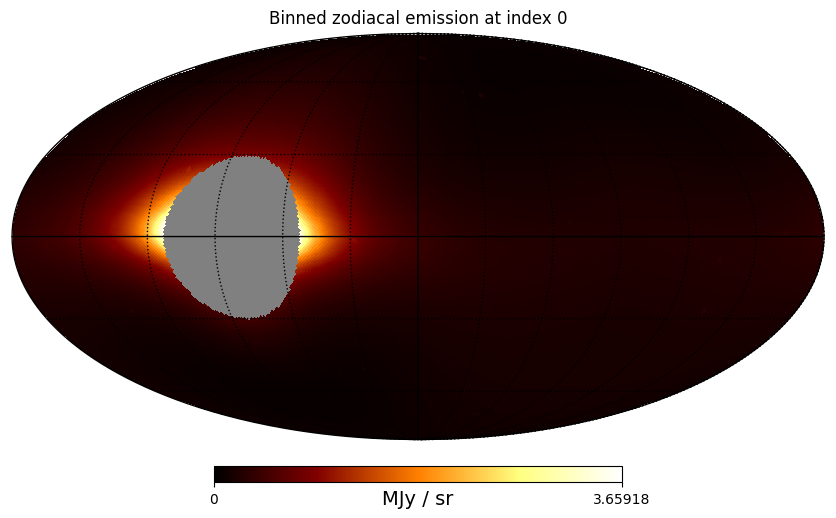

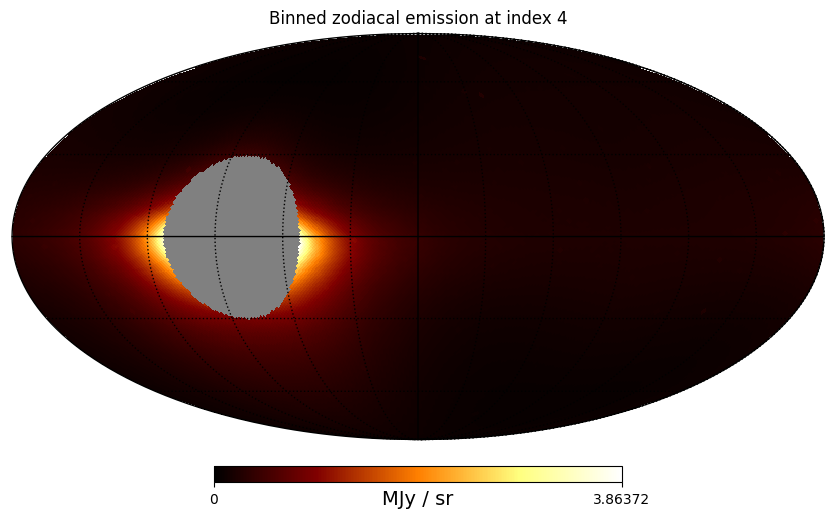

In [11]:
plot_skymap_indices(binned_emission[..., -1, :], 2, title="Binned zodiacal emission", min=0)

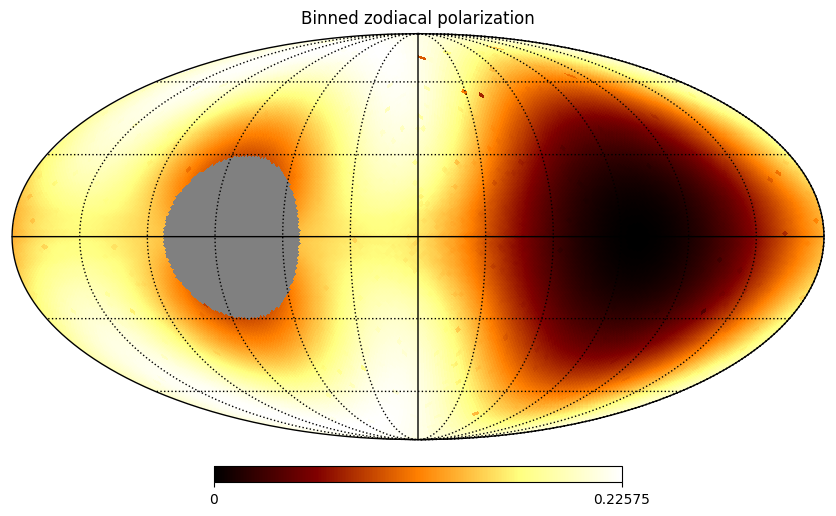

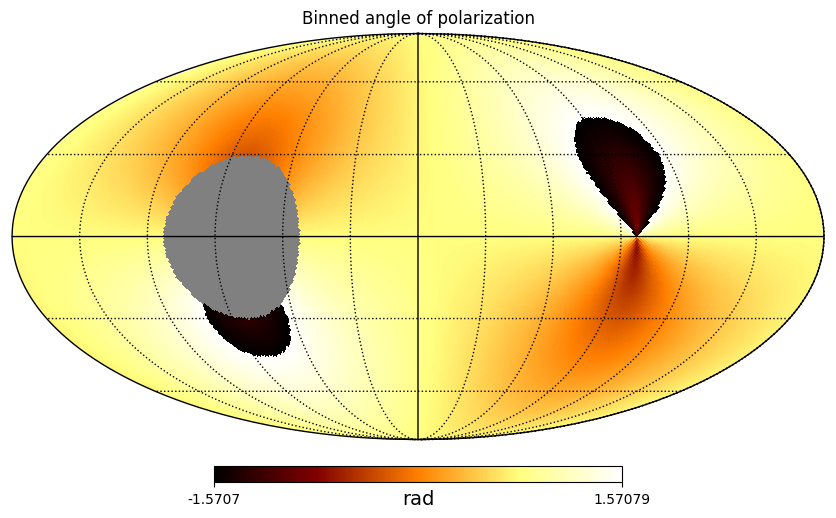

In [13]:
plot_skymap(binned_dolp[..., -1], title="Binned zodiacal polarization", min=0)
plot_skymap(binned_aop[..., -1], title="Binned angle of polarization")

# Displaying camera unnoised results

In [14]:
n_electrons = imager.intensity_to_number_of_electrons(binned_emission, frequency=frequency, weights=imager_response)
n_electrons += imager.camera_dark_current_estimation()
n_electrons = imager.camera_post_process(n_electrons)
camera_intensity = imager.number_of_electrons_to_intensity(n_electrons, frequency, imager_response)
I, Q, U = estimate_IQU(camera_intensity, polarization_angle)
camera_dolp = estimate_DoLP(I, Q, U)
camera_aop = estimate_AoP(Q, U)

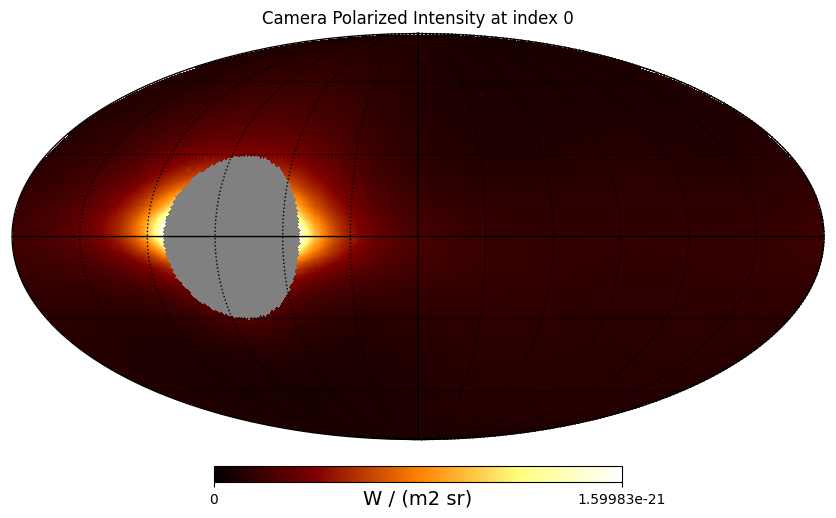

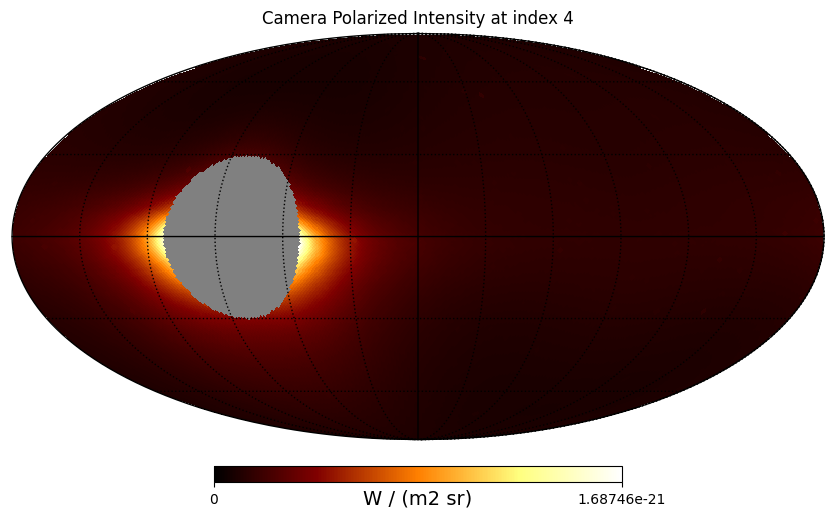

In [15]:
plot_skymap_indices(camera_intensity, 2, title="Camera Polarized Intensity", min=0)

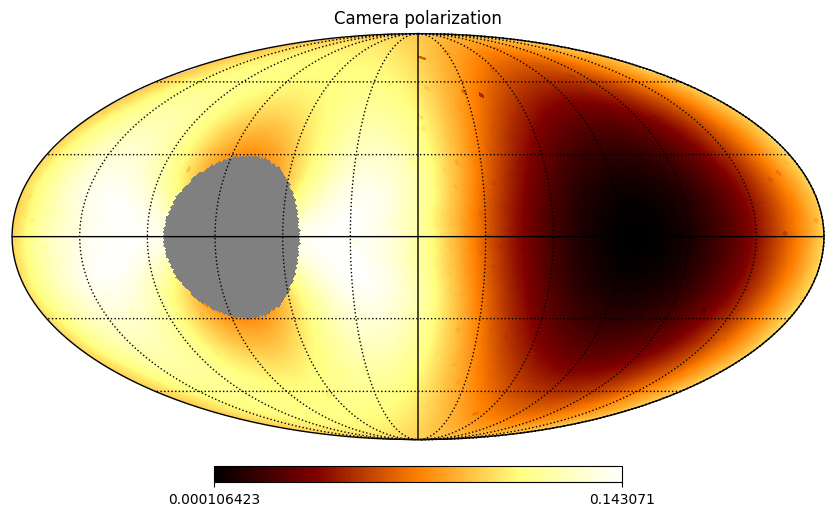

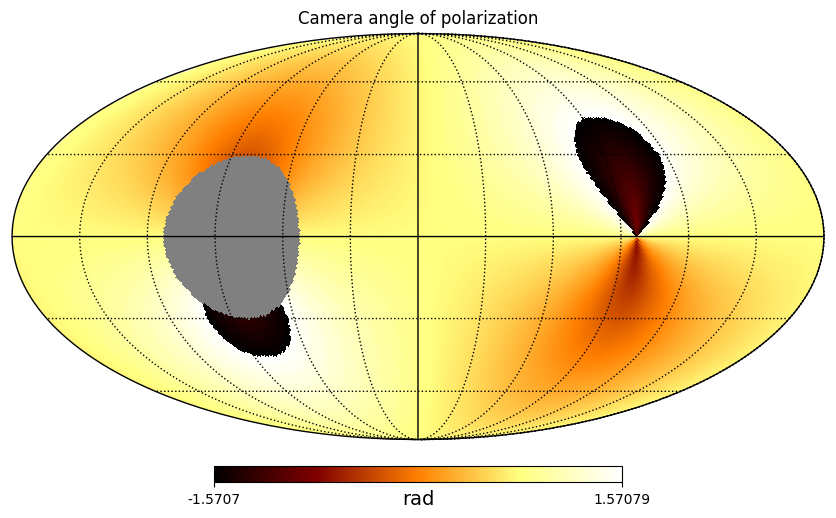

In [16]:
plot_skymap(camera_dolp, title="Camera polarization")
plot_skymap(camera_aop, title="Camera angle of polarization")

## Displaying camera noised results

In [17]:
n_electrons = imager.intensity_to_number_of_electrons(binned_emission, frequency=frequency, weights=imager_response)
n_electrons_noised = imager.imager_noise_model(n_electrons)
camera_intensity = imager.number_of_electrons_to_intensity(n_electrons_noised, frequency, imager_response)

I, Q, U = estimate_IQU(camera_intensity, polarization_angle)
camera_dolp = estimate_DoLP(I, Q, U)
camera_aop = estimate_AoP(Q, U)

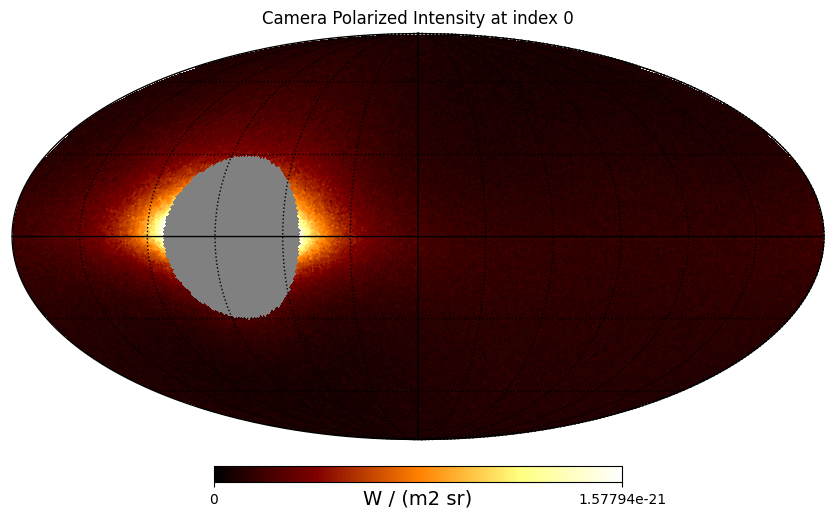

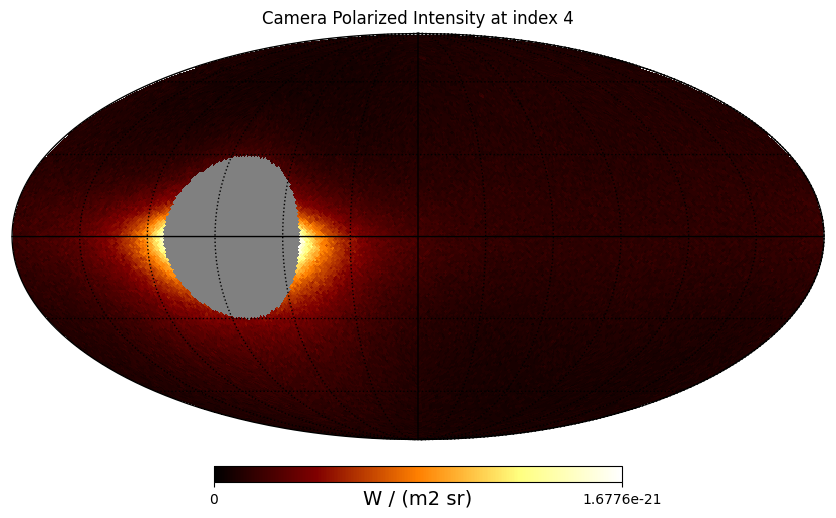

In [18]:
plot_skymap_indices(camera_intensity, 2, title="Camera Polarized Intensity", min=0)

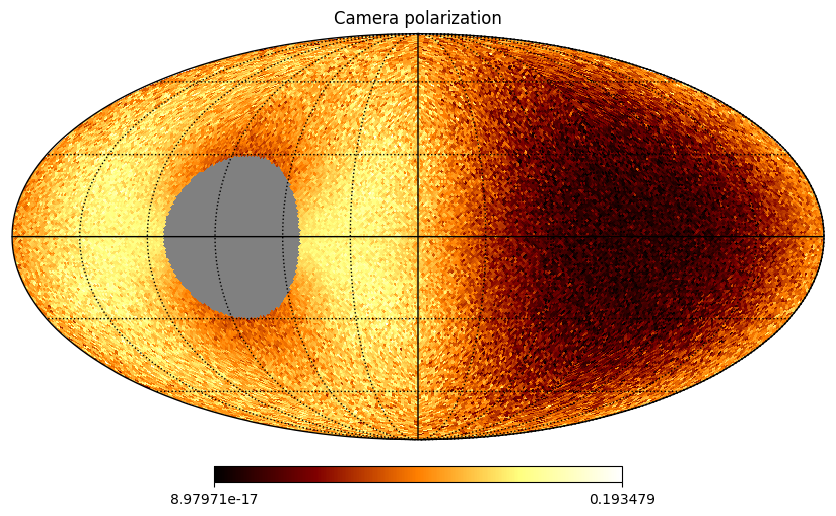

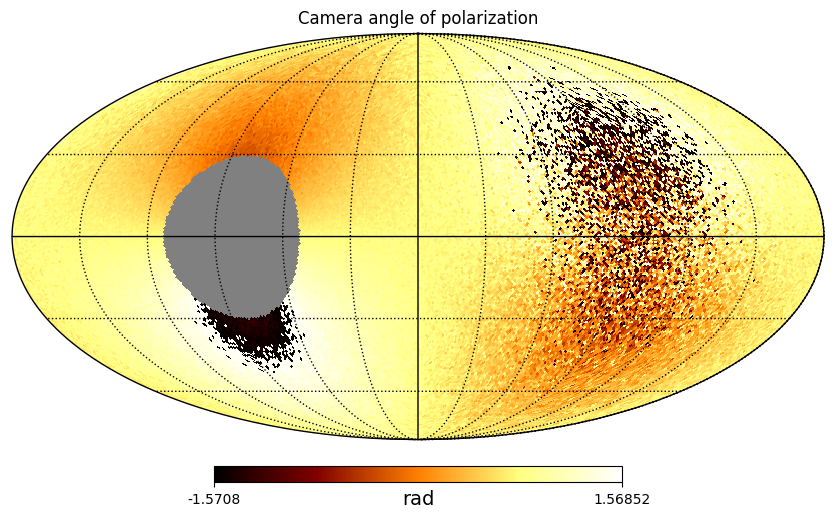

In [20]:
plot_skymap(camera_dolp, title="Camera polarization")
plot_skymap(camera_aop, title="Camera angle of polarization")